# Adaptive RAG
- Framework that dynamically adjusts its strategy for handling queries based on their complexity
- Chooses the most appropriate retrieval method for each query
- Knows when to dive deep and when to generate quick responses
- Combines query analysis with self corrective RAGs

In [19]:
import os
from dotenv import load_dotenv
from langchain_groq import ChatGroq
load_dotenv()
os.environ['GROQ_API_KEY'] = os.getenv('GROQ_API_KEY')
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')
os.environ['TAVILY_API_KEY'] = os.getenv('TAVILY_API_KEY')

In [20]:
## Build an index
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings


# embeddings
embd = OpenAIEmbeddings()

# Docs to index
urls = [
    'https://lilianweng.github.io/posts/2023-06-23-agent/',
    'https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/',
    'https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/',
]

# load
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

# split text
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=500, chunk_overlap=0)
doc_splits = text_splitter.split_documents(docs_list)

## Vector stores
vector_store = FAISS.from_documents(
    documents = doc_splits,
    embedding=OpenAIEmbeddings()
)

## vector store as retriever
retriever = vector_store.as_retriever()

In [21]:
## Create a router
from typing import Literal
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field


# Data Model
class RouteQuery(BaseModel):
    """ Route the user to the most relevant data source """
    datasource: Literal['vectorstore', 'web_search'] = Field(
        ...,
        description='Given a user question choose to route it to web search or a vector store'
    )
    
llm = ChatOpenAI(model='gpt-4o-mini', temperature=0)
structured_llm_router = llm.with_structured_output(RouteQuery)

# Prompt
system = """ You're an expert at routing a user question to a vectorstrore or web search. 
The vectorstore contains documents related to agents, prompt engineering, and adversarial attacks.
Use the vectorstore for questions on these topics. Otherwise, use web-search"""

route_prompt = ChatPromptTemplate(
    [
        ('system', system),
        ('human', '{question}')
    ]
)

question_router = route_prompt | structured_llm_router

print(question_router.invoke({
    'question': 'Who won the 2024 T20 world cup? What were the main highlights of it?'
}))

print(question_router.invoke({
    'question': 'What are the types of Agent memory?'
}))

datasource='web_search'
datasource='vectorstore'


In [22]:
## Retrieval grader

# Data Model
class GradeDocuments(BaseModel):
    """ Binary score relevance check for retrieved documents"""
    
    binary_score:str = Field(
        description='Documents are relevant to the question \'yes\' or \'no\''
    )
    
## LLM with structured output
llm_grader = ChatOpenAI(model='gpt-4o-mini', temperature=0)
structured_llm_grader = llm_grader.with_structured_output(GradeDocuments)

## Prompt
system = """ You're an expert grader assessing relevance of retrieved documents to a user question. \n
If the document contains relevant keyword(s) or sementically meaningful content related to user question, grade it as relevant. \n
It doesn't need to be a stringent test. The goal is to filter out erroneous/irrelavnt retrievals. \n
Give a binary score of yes or no to indicate whether the document is relevant to the question. """

grader_prompt =ChatPromptTemplate.from_messages([
   ('system', system),
   ('human', 'Retrieved document:  \n\n {document} \n\n User Question: {question}') 
])

retrieval_grading_chain = grader_prompt | structured_llm_grader

question = 'Agent memory'
docs= retriever.invoke(question)
doc_text = docs[1].page_content

print(retrieval_grading_chain.invoke({'question': question, 'document': doc_text}))

binary_score='yes'


In [ ]:
## Content generator node
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

# prompt for generation
prompt = hub.pull('rlm/rag-prompt')

# LLM
generation_llm = ChatOpenAI(model='gpt-4o-mini', temperature=0)

# doc formatting
def post_processing(docs):
    return '\n\n'.join(doc.page_content for doc in docs)

# Rag chain
rag_chain = prompt | generation_llm | StrOutputParser()

# run rag chain
generation = rag_chain.invoke({
    'context': docs, 
    'question': question
})
print(generation)


In [ ]:
## Checks for Hallucination: Hallucination grader

# Data model
class GradeHallucinations(BaseModel):
    """ Binary Score for hallucination presence in the documents """
    binary_score : str = Field(
        description= 'Answer is grounded in the facts \'yes\' or \'no\''
    )
    
llm = ChatOpenAI(model='gpt-4o-mini', temperature=0)
hallucinaiton_grader_llm = llm.with_structured_output(GradeHallucinations)

# prompt
system = """ You're an expert grader in assessing whether the LLM generation is grounded in/supported by set of retrieval facts. \n
Give a binary score 'yes' or 'no'. 'yes' means answer is grounded in / supported by the set of facts"""

hallucination_prompt = ChatPromptTemplate.from_messages([
    ('system', system),
    ('human', 'set of facts : \n\n {documents} \n\n LLM generation: {generation}')
])

hallucination_grader_chain = hallucination_prompt | hallucinaiton_grader_llm
hallucination_grader_chain.invoke({
    'documents': docs,
    'generation':generation
})

GradeHallucinations(binary_score='yes')

In [ ]:
## Answer Grader

# Data model 
class GradeAnswer(BaseModel):
    """ Binary score to assess if answer addresses the question """
    binary_score: str = Field(
        description='Answer addresses the quesiton \'yes\' or \'no\''
    )
    
## answer grader llm
llm = ChatOpenAI(model = 'gpt-4o-mini', temperature=0)
answer_grader_llm = llm.with_structured_output(GradeAnswer)

# prompt
system = """ You're and expert grader in assessing where the answer addresses / resolves a question \n
Give a binary score 'yes' or 'no'. 'Yes' means the answer addresses / resolves the question. """

answer_prompt = ChatPromptTemplate.from_messages([
    ('system', system),
    ('human', 'User question: \n\n {question} \n\n LLM generation: {generation}')
])
answer_grader = answer_prompt | answer_grader_llm
answer_grader.invoke({
    'question':question,
    'generation': generation
})

GradeAnswer(binary_score='yes')

In [ ]:
## Question rewriter

# LLM
llm = ChatOpenAI(model='gpt-4o-mini', temperature=0)

#prompt
system = """ You're a question rewriter that converts an input question to a better version that is optimized \n
for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning"""

rewrite_prompt = ChatPromptTemplate.from_messages([
    ('system', system),
    ('human', 'Here is the inital question: \n\n {question} \n Formulate an improved question.')
])

question_rewriter = rewrite_prompt | llm | StrOutputParser()
question_rewriter.invoke({
    'question': question
})


'What are the key concepts and benefits of agent memory in artificial intelligence?'

In [ ]:
## Search
from langchain_community.tools.tavily_search import TavilySearchResults
web_search_tool = TavilySearchResults(k=3)

/var/folders/15/xbwr_x_d51sf0lj4mptglw6h0000gn/T/ipykernel_52394/406609262.py:3: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  web_search_tool = TavilySearchResults(k=3)


# Graph Implementation

In [ ]:
## Implementing graph
from typing import List
from typing_extensions import TypedDict

class GraphState(TypedDict):
    """
    Represents the state of our graph

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """
    question: str
    generation: str
    documents: List[str]

In [ ]:
from langchain.schema import Document


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state
        
    Returns: 
        state (dict): New key added to the state, documents, that contains retrieved documents 
    """
    print('--- RETRIEVE ---')
    question = state['question']
    
    # retrieval
    documents = retriever.invoke(question)
    return {'documents':documents, 'question': question}

def generate(state):
    """
    Generate an answer

    Args:
        state (state): The current graph state 
        
    Returns: 
        state (dict): New key added to the state, generation, that contains LLM generation
    """
    print('--- GENERATE ---')
    question = state['question']
    documents = state['documents']
    
    # RAG generation
    generation = rag_chain.invoke({'context':documents, 'question': question})
    return {'documents':documents, 'question': question, 'generation': generation}

def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question

    Args:
        state (state): The current graph state 
        
    Returns: 
        state (dict): Update documents key with only the filtered documents
    """
    
    print('--- CHECK DOCUMENT RELEVANCE TO QUESTION ---')
    question = state['question']
    documents = state['documents']
    
    # score each doc
    filtered_docs = []
    for d in documents:
        score = retrieval_grading_chain.invoke({
            'question':question,
            'document':d.page_content
        })
        grade = score.binary_score
        if grade=='yes':
            print('--- GRADE: DOC RELEVANT ---')
            filtered_docs.append(d)
        else:
            print('--- GRADE: DOC NOT RELEVANT ---')
            continue
    return {'documents': filtered_docs, 'question':question}

def transform_query(state):
    """Transform the query to produce a better question

    Args:
        state (dict): The current state of the graph
        
    Returns:
        state (dict): Updates the key with re-phrased question
    """
    
    print('--- TRANSFORM QUERY ---')
    question = state['question']
    documents = state['documents']
    
    # rewrite question
    better_question = question_rewriter.invoke({'question':question})
    return {'documents':documents, 'question':better_question}
    
def web_search(state):
    """Web search based on rephrased question

    Args:
        state (dict): The current graph state
        
    Returns:
        state (dict): Updates documents key with appended web results
    """
    
    print('--- WEB SEARCH ---')
    question = state['question']
    
    # web search
    docs = web_search_tool.invoke({'query':question})
    web_results = '\n'.join([d['content'] for d in docs])
    web_results= Document(page_content=web_results)
    return {'documents':web_results, 'question':question}

def route_question(state):
    """
    Route question to web search or RAG

    Args:
        state (dict): The current graph state
        
    Returns: 
        str: Next node to call
    """
    print('--- ROUTE QUESTION ---')
    question = state['question']
    source =  question_router.invoke({
        'question':question
    })
    if source.datasource == 'web_search':
        print('--- ROUTE TO WEB SEARCHG ---')
        return "web_search"
    elif source.datasource == 'vectorstore':
        print('--- ROUTE QUESTION TO RAG ---')
        return 'vectorstore'
    

def decide_to_generate(state):
    """Determines whether to generate an answer or re-generate the question

    Args:
        state (dict): The current graph state
        
    Returns:
        str: Binary decision for next node call
    """
    
    print('--- ASSESS GRADED DOCUMENTS ---')
    filtered_documents = state['documents']
    
    if not filtered_documents:
        print('--- DECISION: NO RELEVANT DOCUMENTS FOUND ---')
        return 'transform_query'
    else: 
        print('--- DECISION: GENERATE --- ')
        return 'generate'

def grade_generation_v_documents_and_question(state):
    """
    Determines whether the question is grounded in the document or answers the question

    Args:
        state (dict): The current graph state
        
    Returns:
        str: Decision for the next node to call
    """
    print('--- CHECK HALLUCINATIONS ---')
    question = state['question']
    documents = state['documents']
    generation = state['generation']
    
    score = hallucination_grader_chain.invoke({
        'documents':documents,
        'generation':generation
    })
    grade = score.binary_score
    
    # check hallucination
    if grade == 'yes':
        print('--- DECISION: GENERATION IS GROUNDED IN DOCUMENTS ---')
        print('--- GRADE GENERATION VS QUESTION ---')
        score = answer_grader.invoke({
            'question':question,
            'generation':generation
        })
        grade = score.binary_score
        if grade =='yes':
            print('--- DECISION: GENERATION ADDRESSES QUESTION ---')
            return 'useful'
        else:
            print('--- DECISION: GENERATION DOESN\'T ADDRESSES QUESTION ---')
            return 'not useful'
    else:
        print('--- DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE TRY ---')
        return 'not supported'
    

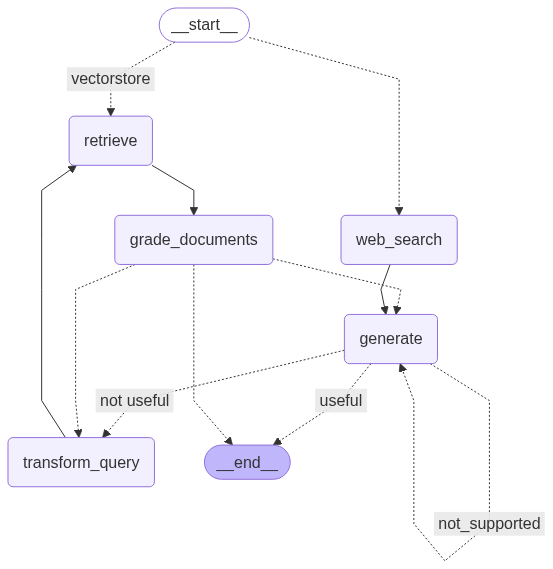

In [ ]:
## Create state graph
from langgraph.graph import START, StateGraph, END
from IPython.display import Image, display
workflow = StateGraph(GraphState)

## add nodes
workflow.add_node('web_search', web_search)
workflow.add_node('retrieve', retrieve)
workflow.add_node('grade_documents', grade_documents)
workflow.add_node('generate', generate)
workflow.add_node('transform_query', transform_query)

# add edges
workflow.add_conditional_edges(
    START,
    route_question,
    {
        'web_search':'web_search',
        'vectorstore':'retrieve'
    },
)
workflow.add_edge('web_search', 'generate')
workflow.add_edge('retrieve', 'grade_documents')
workflow.add_conditional_edges(
    'grade_documents',
    decide_to_generate,
    {
        'transform_query':'transform_query',
        'generate':'generate'
    },
)
workflow.add_edge('transform_query', 'retrieve')
workflow.add_conditional_edges(
    'generate',
    grade_generation_v_documents_and_question,
    {
        'not_supported':'generate',
        'useful':END,
        'not useful': 'transform_query'
    },
)

app = workflow.compile()

display(Image(app.get_graph().draw_mermaid_png()))

In [15]:
app.invoke({'question': 'What is machine learning?'})

--- ROUTE QUESTION ---
--- ROUTE TO WEB SEARCHG ---
--- WEB SEARCH ---
--- GENERATE ---
--- CHECK HALLUCINATIONS ---
--- DECISION: GENERATION IS GROUNDED IN DOCUMENTS ---
--- GRADE GENERATION VS QUESTION ---
--- DECISION: GENERATION ADDRESSES QUESTION ---


{'question': 'What is machine learning?',
 'generation': 'Machine learning is a subfield of artificial intelligence that enables computers to learn from past experiences or input data to make future predictions without being explicitly programmed. It involves the use of algorithms to analyze data, identify patterns, and improve performance over time. Common categories of machine learning include supervised learning, unsupervised learning, and reinforcement learning.',
 'documents': Document(metadata={}, page_content='## What is machine learning?\n\nMachine learning is a subfield of artificial intelligence, which is broadly defined as the capability of a machine to imitate intelligent human behavior. Artificial intelligence systems are used to perform complex tasks in a way that is similar to how humans solve problems. [...] When companies today deploy artificial intelligence programs, they are most likely using machine learning — so much so that the terms are often used interchangeably

In [18]:
app.invoke({'question':'what is agent memory?'})

--- ROUTE QUESTION ---


KeyError: None